In [8]:
import datetime

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from transformers import BertTokenizer
import spacy

# Load Data
train = pd.read_csv('../public_data/train/track_a/eng.csv')
val = pd.read_csv('../public_data/dev/track_a/eng_a.csv')
emotions = ['Joy', 'Sadness', 'Surprise', 'Fear', 'Anger']

# Preprocessing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
nlp = spacy.load("en_core_web_sm")
vectorizer = CountVectorizer()

def pre_process(text):
    tokens = tokenizer.tokenize(text.lower())  # Lowercase and tokenize
    doc = nlp(" ".join(tokens))  # POS tagging
    tokens += [token.pos_ for token in doc]  # Append POS tags
    return " ".join(tokens)

X_train_text = [pre_process(i) for i in train["text"]]
X_val_text = [pre_process(i) for i in val["text"]]

# Feature Extraction
X_train = vectorizer.fit_transform(X_train_text).toarray()
X_val = vectorizer.transform(X_val_text).toarray()

# POS Encoding
train_pos_tags = [[token.pos_ for token in nlp(text)] for text in train["text"]]
val_pos_tags = [[token.pos_ for token in nlp(text)] for text in val["text"]]

max_length = max(max(len(tags) for tags in train_pos_tags), max(len(tags) for tags in val_pos_tags))
train_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in train_pos_tags]
val_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in val_pos_tags]

encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
train_pos_encoded = encoder.fit_transform(train_pos_tags)
val_pos_encoded = encoder.transform(val_pos_tags)

# Combine Features
combined_features = np.concatenate((X_train, train_pos_encoded), axis=1)
validation_combined_features = np.concatenate((X_val, val_pos_encoded), axis=1)

# Reshape y_train for Logistic Regression
y_train = train[emotions].values
y_train_flat = np.argmax(y_train, axis=1)  # Convert multi-hot labels to single-label for classifiers

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(combined_features, y_train_flat)

# Generate additional features
lr_features = lr.predict_proba(combined_features)
val_lr_features = lr.predict_proba(validation_combined_features)

# Combine with original features
final_train_features = np.concatenate((combined_features, lr_features), axis=1)
final_val_features = np.concatenate((validation_combined_features, val_lr_features), axis=1)

# Neural Network
model = nn.Sequential(
    nn.Linear(final_train_features.shape[1], 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1])
)

# Convert to tensors
features_tensor = torch.tensor(final_train_features, dtype=torch.float32)
labels_tensor = torch.tensor(y_train, dtype=torch.float32)
val_features_tensor = torch.tensor(final_val_features, dtype=torch.float32)
val_labels_tensor = torch.tensor(val[emotions].values, dtype=torch.float32)

# DataLoader
batch_size = 16
dataset = TensorDataset(features_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Training Loop
losses = []
for epoch in tqdm(range(1000), desc="Training Loop"):
    for features, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss: {loss.item()}")
    losses.append(loss.item())

# Output Final Loss
print(f"Final Loss after 1000 epochs: {losses[-1]}")


c:\Users\agupt\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\agupt\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
Training Loop:   0%|          | 1/1000 [00:02<44:24,  2.67s/it]

Epoch 0: Loss: 0.5531610250473022


Training Loop:  10%|█         | 101/1000 [04:58<38:14,  2.55s/it] 

Epoch 100: Loss: 0.015423377975821495


Training Loop:  20%|██        | 201/1000 [10:17<38:37,  2.90s/it]  

Epoch 200: Loss: 0.003945645876228809


Training Loop:  30%|███       | 301/1000 [15:06<33:52,  2.91s/it]

Epoch 300: Loss: 0.04182000458240509


Training Loop:  40%|████      | 401/1000 [21:31<28:22,  2.84s/it]  

Epoch 400: Loss: 0.010825814679265022


Training Loop:  50%|█████     | 501/1000 [25:22<18:19,  2.20s/it]

Epoch 500: Loss: 0.0008097641984932125


Training Loop:  60%|██████    | 601/1000 [32:05<29:55,  4.50s/it]

Epoch 600: Loss: 0.0012398697435855865


Training Loop:  70%|███████   | 701/1000 [38:30<15:01,  3.01s/it]

Epoch 700: Loss: 0.036138493567705154


Training Loop:  80%|████████  | 801/1000 [42:57<08:45,  2.64s/it]

Epoch 800: Loss: 0.010699165984988213


Training Loop:  90%|█████████ | 901/1000 [48:01<03:53,  2.36s/it]

Epoch 900: Loss: 0.00323837180621922


Training Loop: 100%|██████████| 1000/1000 [52:25<00:00,  3.15s/it]

Final Loss after 1000 epochs: 0.013590453192591667


In [5]:
val_features_tensor

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.4611e-02, 4.1625e-03,
         2.9160e-04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8312e-01, 2.9252e-01,
         1.3352e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.5816e-02, 6.5488e-03,
         1.0337e-03],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.6322e-02, 2.5584e-01,
         5.8693e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.8141e-01, 1.4120e-01,
         2.7523e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.2213e-01, 2.6148e-02,
         5.2471e-02]])

In [9]:
def get_predictions(X_val, model, threshold=0.5):
    sig = nn.Sigmoid() 
    yhat = sig(model(X_val)).detach().numpy()
    y_pred = yhat > threshold
    
    return y_pred

y_pred = get_predictions(val_features_tensor, model, 0.45)
# print(y_pred)

# Create a DataFrame to save to CSV
val_data_with_pred = pd.DataFrame(y_pred, columns=['Anger', 'Fear', 'Joy', 'Sadness', 'Surprise'])  # Adjust column names as per your features
# val_data_with_pred['True_Label'] = y_test
# val_data_with_pred['Predictions'] = dummy_predictions

val_data_with_pred = val_data_with_pred.astype(int)

val_data_with_pred['id'] = val['id']

val_data_with_pred = val_data_with_pred[['id', 'Anger', 'Fear', 'Joy', 'Sadness', 'Surprise']]

# Save to CSV
current_time = datetime.datetime.now()
formatted_time = current_time.strftime('%Y-%m-%d_%H_%M_%S')

val_data_with_pred.to_csv(f'../results/pred_eng_a_{formatted_time}.csv', index=False)

print(val_data_with_pred)

                        id  Anger  Fear  Joy  Sadness  Surprise
0    eng_dev_track_a_00001      0     1    1        1         0
1    eng_dev_track_a_00002      0     0    0        1         0
2    eng_dev_track_a_00003      1     0    0        0         0
3    eng_dev_track_a_00004      0     0    0        1         0
4    eng_dev_track_a_00005      0     1    0        1         0
..                     ...    ...   ...  ...      ...       ...
111  eng_dev_track_a_00112      0     0    1        1         0
112  eng_dev_track_a_00113      0     0    1        1         0
113  eng_dev_track_a_00114      1     0    0        0         0
114  eng_dev_track_a_00115      0     0    0        0         0
115  eng_dev_track_a_00116      0     0    1        0         0

[116 rows x 6 columns]


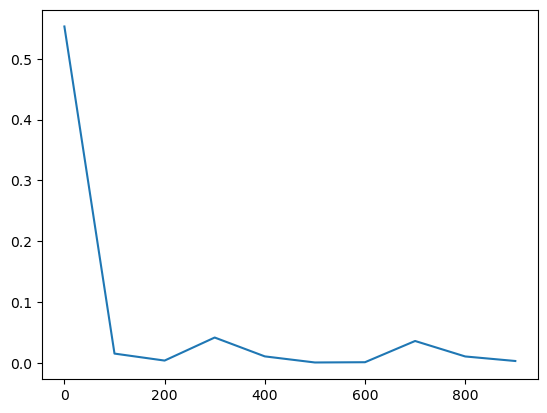

In [1]:
import matplotlib.pyplot as plt

x = [100*i for i in range(10)]
y = [0.5531610250473022, 0.015423377975821495, 0.003945645876228809, 0.04182000458240509, 0.010825814679265022, 0.0008097641984932125, 0.0012398697435855865, 0.036138493567705154, 0.010699165984988213, 0.00323837180621922]

plt.plot(x, y)